In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-17aanso5 because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
dataset_dim = 3

In [3]:
dataset = sklearn.datasets.make_swiss_roll(n_samples=300, noise=1.0, random_state=None)
print(min(dataset[1]),max(dataset[1]))
dataset = dataset[0][dataset[1]<10][:30]/10

4.749789003257456 14.01774134216364


In [4]:
dataset

array([[ 0.36957511,  0.34282075, -0.31401447],
       [ 0.64794818,  1.37922992,  0.06352962],
       [-0.05391676,  0.3719325 ,  0.92022395],
       [ 0.08218992,  0.67799725,  0.78752037],
       [ 0.62738549,  1.5708042 , -0.22144352],
       [ 0.37701206,  0.75015878,  0.43542259],
       [-0.73070517,  0.26097325,  0.33764782],
       [-0.72017596,  2.01251167,  0.60556017],
       [ 0.54099776,  1.06812365,  0.05836452],
       [ 0.61139138,  0.39531337,  0.20644333],
       [-0.80074166,  0.89722752, -0.04491881],
       [-0.13014607,  2.04904279,  0.87708756],
       [-0.80529065,  1.41147236, -0.00349651],
       [ 0.48115919,  1.40604562,  0.09962999],
       [ 0.46234727,  0.28031267,  0.55742324],
       [-0.78693401,  0.46606934,  0.38879551],
       [ 0.40177174,  0.10683742, -0.14724023],
       [ 0.07217537,  0.3763347 , -0.39407392],
       [ 0.42067974,  2.1062818 , -0.06210636],
       [ 0.44074554,  0.76745291,  0.58544013],
       [-0.11567528,  0.87775638,  0.863

<IPython.core.display.Javascript object>


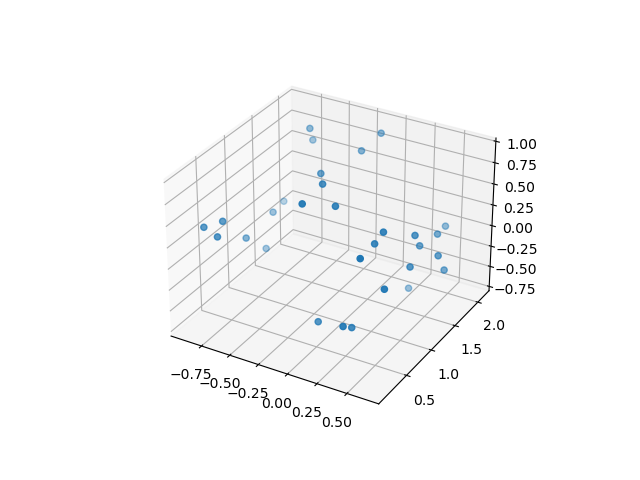

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);

# 1D VAE Fit to Dataset

In [6]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [7]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    

In [8]:
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [9]:
testname = "pedagogical/swiss"

In [10]:
all_models=[]
all_exceptions = []
for curvreg in [0,0.001,0.01,0.1,1]:
    for secreg in [0,0.01,0.1,1]:
        if curvreg != 0 and secreg != 0:
            continue
        for beta in [0.01]:
            for latentdim in [2]:
                for epsilon_scale_start in [2]:
                    try:
                        vae = make_vae(latent_dim=latentdim).to(device)
                        num_epochs = 300
                        savedir  = f'{testname}lat{latentdim}_secreg{secreg}_curvreg{curvreg}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                        print(savedir)
                        trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
                            log_dir=savedir, lr=0.0005, annealingBatches=0, record_loss_every=50, loss_func = "gaussian")
                        scheduler = torch.optim.lr_scheduler.ExponentialLR(trainer.optimizer, gamma=0.1)
                        epoch = 0
                        epsilon_scale = epsilon_scale_start
                        for _ in range(num_epochs*3):
                            epoch+=1
                            # had an off-by-one error here before
                            # update values BEFORE training 501st element
                            if epoch % num_epochs == 1 and epoch > 1: 
                                scheduler.step()
                                trainer.beta = trainer.beta * 1.0 #0.1
                                epsilon_scale = epsilon_scale * 0.8 #0.1
                                curvreg = curvreg * np.sqrt(10)
                                secreg = secreg * np.sqrt(10)
                            embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=curvreg, epsilon_scale = epsilon_scale, num_new_samp_points=128)
                            is_error = embst[0]
                            if is_error:
                                raise Exception
                        sm.save_fcpassthrough_vae(vae, savedir)
                        print(savedir)
                        all_models.append(savedir)
                    except:
                        raise

pedagogical/swisslat2_secreg0_curvreg0_beta0.01_20220201-123902
pedagogical/swisslat2_secreg0_curvreg0_beta0.01_20220201-123902
pedagogical/swisslat2_secreg0.01_curvreg0.0_beta0.01_20220201-124008
pedagogical/swisslat2_secreg0.01_curvreg0.0_beta0.01_20220201-124008
pedagogical/swisslat2_secreg0.1_curvreg0.0_beta0.01_20220201-124132
pedagogical/swisslat2_secreg0.1_curvreg0.0_beta0.01_20220201-124132
pedagogical/swisslat2_secreg1_curvreg0.0_beta0.01_20220201-124258
pedagogical/swisslat2_secreg1_curvreg0.0_beta0.01_20220201-124258
pedagogical/swisslat2_secreg0_curvreg0.001_beta0.01_20220201-124424
pedagogical/swisslat2_secreg0_curvreg0.001_beta0.01_20220201-124424
pedagogical/swisslat2_secreg0_curvreg0.01_beta0.01_20220201-124552
pedagogical/swisslat2_secreg0_curvreg0.01_beta0.01_20220201-124552
pedagogical/swisslat2_secreg0_curvreg0.1_beta0.01_20220201-124722
pedagogical/swisslat2_secreg0_curvreg0.1_beta0.01_20220201-124722
pedagogical/swisslat2_secreg0_curvreg1_beta0.01_20220201-124851


In [11]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [12]:
def make_2d_grid_points(xmin, xmax, ymin, ymax, ):
    #lim = 6
    num_few = 7
    num_many = 100
    pts = []
    for x in np.linspace(xmin, xmax, num_few):
        for y in np.linspace(ymin, ymax, num_many):
                pts.append((x,y))
    for y in np.linspace(ymin, ymax, num_few):
        for x in np.linspace(xmin, xmax, num_many):
                pts.append((x,y))
    return np.array(pts)

<IPython.core.display.Javascript object>


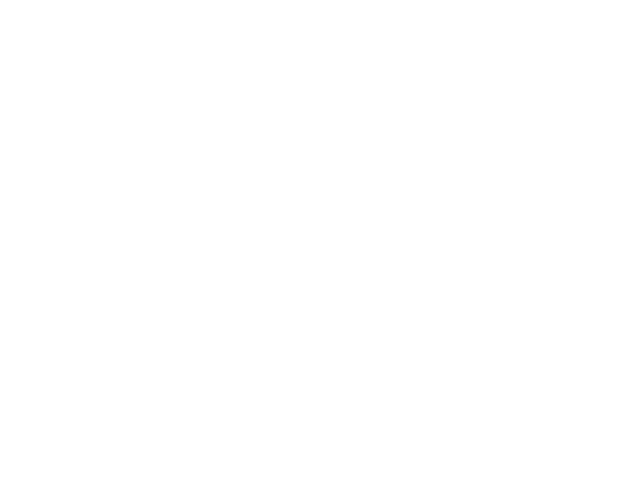

pedagogical/swisslat2_secreg0_curvreg0_beta0.01_20220201-123902


<IPython.core.display.Javascript object>


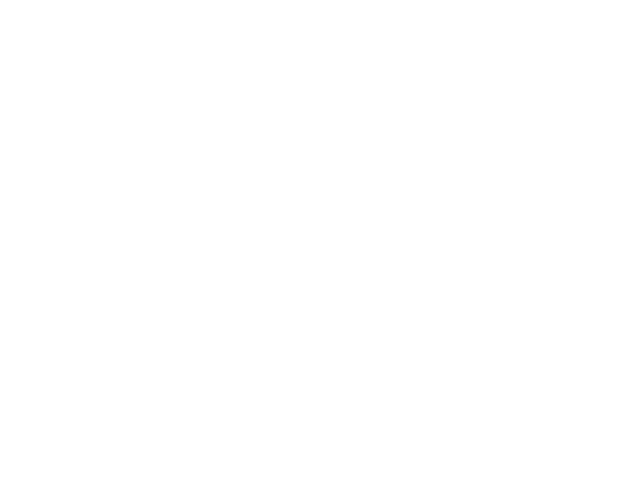

pedagogical/swisslat2_secreg0.01_curvreg0.0_beta0.01_20220201-124008


<IPython.core.display.Javascript object>


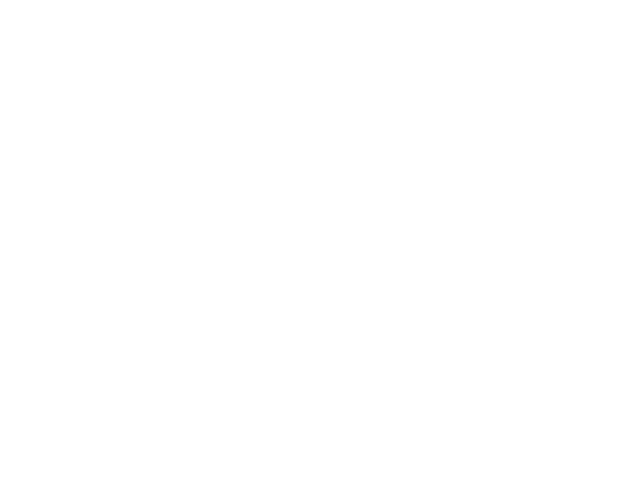

pedagogical/swisslat2_secreg0.1_curvreg0.0_beta0.01_20220201-124132


<IPython.core.display.Javascript object>


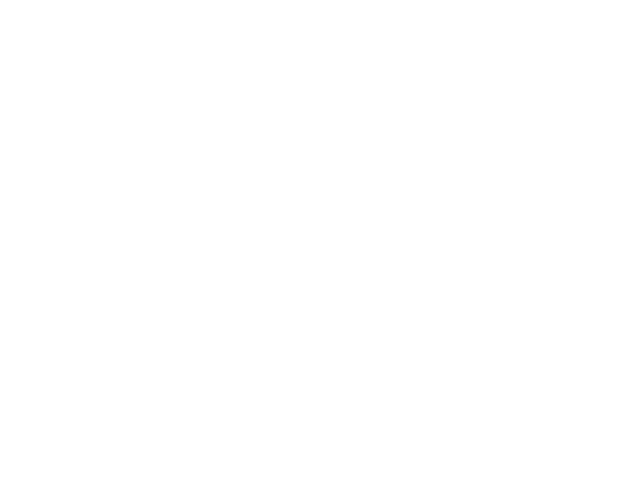

pedagogical/swisslat2_secreg1_curvreg0.0_beta0.01_20220201-124258


<IPython.core.display.Javascript object>


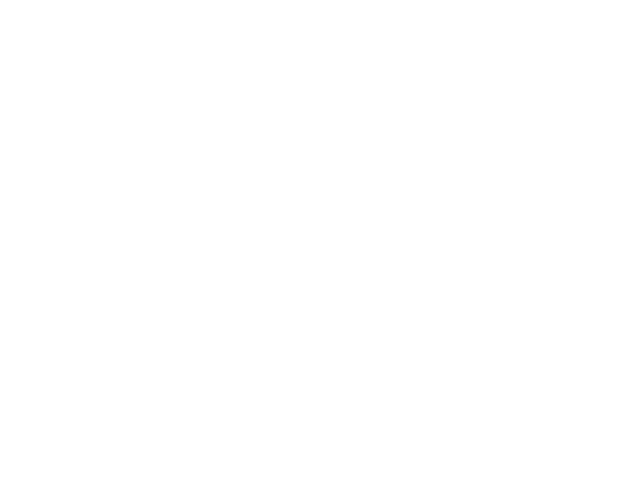

pedagogical/swisslat2_secreg0_curvreg0.001_beta0.01_20220201-124424


<IPython.core.display.Javascript object>


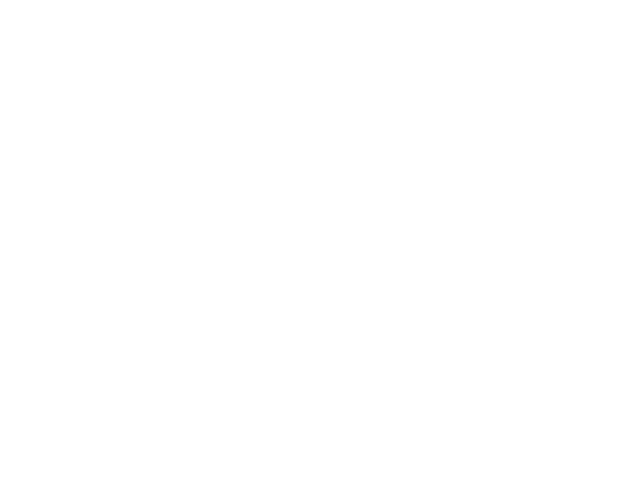

pedagogical/swisslat2_secreg0_curvreg0.01_beta0.01_20220201-124552


<IPython.core.display.Javascript object>


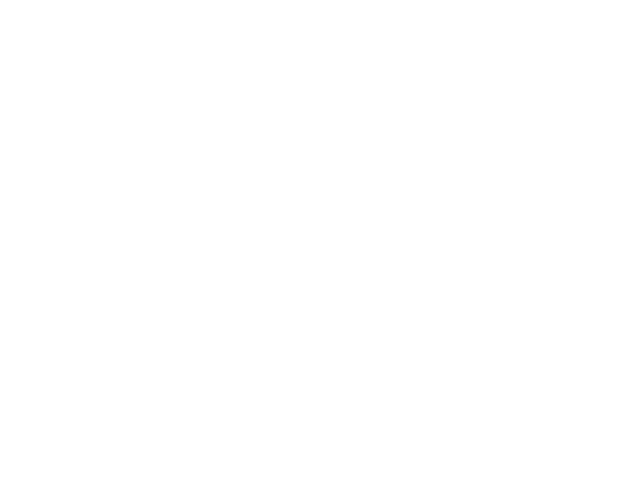

pedagogical/swisslat2_secreg0_curvreg0.1_beta0.01_20220201-124722


<IPython.core.display.Javascript object>


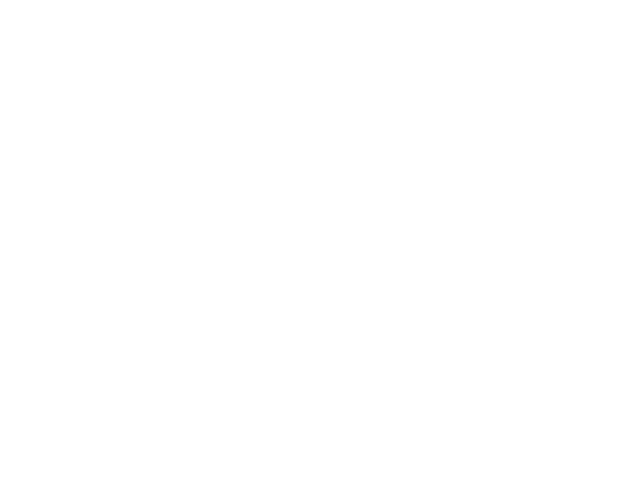

pedagogical/swisslat2_secreg0_curvreg1_beta0.01_20220201-124851


In [13]:

for i, modelpath in enumerate(all_models):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    print(modelpath)
    vae = lm.load_model(modelpath)
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    pts = make_2d_grid_points(np.min(embeds[:,0]),np.max(embeds[:,0]),
                              np.min(embeds[:,1]),np.max(embeds[:,1]))
    readout = vae.decode(torch.tensor(pts,dtype=torch.float),
              torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
    
    ax.scatter(dataset[:,0],dataset[:,1],dataset[:,2]);
    ax.scatter(readout[:,0],readout[:,1],readout[:,2], alpha=0.5);